## Building simple models for the prediction function on the streamlit website

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for modeling 
from sklearn.linear_model import LinearRegression
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from numpy import NaN
from sklearn.linear_model import LassoCV, RidgeCV,Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, median_absolute_error


import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
#Read in data 

df = pd.read_csv('data/thisisdf.csv')

In [357]:
#Read in projected mitigation data.
mitigation= pd.read_csv('data/Data2/mitigation_final.csv')

mitigation = mitigation.sort_values(['Country', 'Year'])

mitigation.head()

,Year,mitigation,temp_with_mitigation,precip_mitigation,precip_with_mitigation,Country,cereals,potatoes,beans,sugar,...,Surface temperature anomaly,Population,yield_change,yield_percent_change,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp
0,2000,0.52,20.089,0.02900,9.16500,Afghanistan,8063.0,167857.0,0.0,190000.0,...,1.42,2.078000e+07,-4794.0,-0.012932,0.024,0.036932,16.917833,0.021685,-0.175624,24.650437
160,2001,0.75,20.319,0.18852,9.32452,Afghanistan,10067.0,167857.0,0.0,190000.0,...,1.67,2.160700e+07,2004.0,0.005477,0.024,0.018523,17.448083,0.031343,-0.049079,23.864507
319,2002,0.91,20.479,0.34804,9.48404,Afghanistan,16698.0,164286.0,0.0,190000.0,...,1.78,2.260100e+07,3060.0,0.008317,0.024,0.015683,17.317667,-0.007475,0.413284,33.213400
477,2003,0.74,20.309,0.50756,9.64356,Afghanistan,14580.0,166667.0,0.0,181818.0,...,1.08,2.368100e+07,-7919.0,-0.021346,0.024,0.045346,15.996000,-0.076319,0.064549,33.942645
635,2003,0.74,20.309,0.50756,9.64356,Afghanistan,NaN,NaN,NaN,NaN,...,NaN,2.368087e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Calculate projected temperature and precipitation conditions for the mitigation condition. 

#### Calculations based on NASA's projcted precipitation and temperature projections for 2000 - 2100.

Find data here: https://www.nccs.nasa.gov/services/climate-data-services

In [6]:
#Temperature mitigation


temps_2000 = df[df['Year'] == 2000][['AverageTemperature', 'Country']]

temps_2000['Year'] = 2000

temps_2000['temp_anoms'] = 0

temps_2000.rename(columns = {'AverageTemperature': 'Temperature Projected'}, inplace = True)

temps_2100 = temps_2000.copy()

temps_2100['Temperature Projected'] = temps_2000['Temperature Projected'] + 2.36

temps_2100['Year'] = 2100

temps_2100['temp_anoms'] = (temps_2100['Temperature Projected'] - temps_2000['Temperature Projected']) * 6
temps_full_mitigation = pd.concat([temps_2100, temps_2000])

temps_full_mitigation.reset_index(drop = True)
temps_full_mitigation

#precip_mitigation 

precip_2000 = df[df['Year'] == 2010][['Average monthly precipitation', 'Country']]

precip_2000['Year'] = 2000


precip_2000.rename(columns = {'Average monthly precipitation': 'Precipitation Projected'}, inplace = True)

precip_2100 = precip_2000.copy()

precip_2100['Precipitation Projected'] = precip_2000['Precipitation Projected'] + (precip_2000['Precipitation Projected'] *.06)

precip_2100['Year'] = 2100

precip_full_mitigation = pd.concat([precip_2100, precip_2000])

precip_full_mitigation.reset_index(drop = True)
precip_full_mitigation

,Precipitation Projected,Country,Year
49,1.818899,Afghanistan,2100
102,14.893957,Albania,2100
155,0.824651,Algeria,2100
208,9.438209,Angola,2100
261,4.987031,Argentina,2100
...,...,...,...
7487,9.572493,Zambia,2000
7540,5.102340,Zimbabwe,2000
7593,5.925236,Iceland,2000
7648,27.365833,Samoa,2000


In [7]:
temps_full_mitigation

,Temperature Projected,Country,Year,temp_anoms
49,18.188667,Afghanistan,2100,14.16
102,16.135417,Albania,2100,14.16
155,27.575667,Algeria,2100,14.16
208,25.041500,Angola,2100,14.16
261,17.438833,Argentina,2100,14.16
...,...,...,...,...
7487,22.267500,Zambia,2000,0.00
7540,21.986250,Zimbabwe,2000,0.00
7593,2.676417,Iceland,2000,0.00
7648,27.161667,Samoa,2000,0.00


In [8]:
#Merge temperature and precipitation data for mitigated condition

mit = pd.merge(precip_full_mitigation,temps_full_mitigation, how = 'left', left_on = ['Year', 'Country'], right_on = ['Year', 'Country'])

mit

,Precipitation Projected,Country,Year,Temperature Projected,temp_anoms
0,1.818899,Afghanistan,2100,18.188667,14.16
1,14.893957,Albania,2100,16.135417,14.16
2,0.824651,Algeria,2100,27.575667,14.16
3,9.438209,Angola,2100,25.041500,14.16
4,4.987031,Argentina,2100,17.438833,14.16
...,...,...,...,...,...
335,9.572493,Zambia,2000,22.267500,0.00
336,5.102340,Zimbabwe,2000,21.986250,0.00
337,5.925236,Iceland,2000,2.676417,0.00
338,27.365833,Samoa,2000,27.161667,0.00


In [10]:
#merge these projections back with original data frame. 

mitigation_merged = pd.merge(mitigation, mit, how = 'left', left_on = ['Year', 'Country'], right_on = ['Year', 'Country'])

mitigation_merged

,Year,mitigation,temp_with_mitigation,precip_mitigation,precip_with_mitigation,Country,cereals,potatoes,beans,sugar,...,yield_percent_change,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,Precipitation Projected,Temperature Projected,temp_anoms
0,2000,0.52,20.089,0.02900,9.16500,Afghanistan,8063.0,167857.0,0.0,190000.0,...,-0.012932,0.024,0.036932,16.917833,0.021685,-0.175624,24.650437,1.715942,15.828667,0.00
1,2001,0.75,20.319,0.18852,9.32452,Afghanistan,10067.0,167857.0,0.0,190000.0,...,0.005477,0.024,0.018523,17.448083,0.031343,-0.049079,23.864507,NaN,NaN,NaN
2,2002,0.91,20.479,0.34804,9.48404,Afghanistan,16698.0,164286.0,0.0,190000.0,...,0.008317,0.024,0.015683,17.317667,-0.007475,0.413284,33.213400,NaN,NaN,NaN
3,2003,0.74,20.309,0.50756,9.64356,Afghanistan,14580.0,166667.0,0.0,181818.0,...,-0.021346,0.024,0.045346,15.996000,-0.076319,0.064549,33.942645,NaN,NaN,NaN
4,2003,0.74,20.309,0.50756,9.64356,Afghanistan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16424,2096,2.46,22.029,6.46800,15.60400,Zimbabwe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16425,2097,2.34,21.909,6.48600,15.62200,Zimbabwe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16426,2098,2.44,22.009,6.50400,15.64000,Zimbabwe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16427,2099,2.46,22.029,6.52200,15.65800,Zimbabwe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Feature Engineer data 

mitigation_merged.sort_values(['Country', 'Year'], inplace = True)

mitigation_merged['Temperature Projected'].interpolate(inplace = True)

mitigation_merged['temp_anoms'].interpolate(inplace = True)

mitigation_merged['Precipitation Projected'].interpolate(inplace = True)

mitigation_merged['temp_pct_change'] = (mitigation_merged['Temperature Projected'].pct_change()) * 100

mitigation_merged['precip_change'] = (mitigation_merged['Precipitation Projected'].pct_change()) * 100

# Take the same steps for no mitigation

In [12]:
#Read in data
no_mitigation = pd.read_csv('data/Data2/no_mitigation_final.csv')

### Calculate projected temperature and precipitation conditions for the future based on NASA's no mitigation projections.

In [13]:
#Temperature no mitigation

temps_2000_no = df[df['Year'] == 2000][['AverageTemperature', 'Country']]

temps_2000_no['Year'] = 2000

temps_2000_no['temp_anoms'] = 0
temps_2000_no.rename(columns = {'AverageTemperature': 'Temperature Projected'}, inplace = True)

temps_2100_no = temps_2000_no.copy()

temps_2100_no['Temperature Projected'] = temps_2000_no['Temperature Projected'] + 9.89

temps_2100_no['temp_anoms'] = (temps_2100_no['Temperature Projected'] - temps_2000_no['Temperature Projected']) *6

temps_2100_no['Year'] = 2100

temps_no_mitigation = pd.concat([temps_2100_no, temps_2000_no])


temps_no_mitigation.reset_index(drop = True)
temps_no_mitigation

#precip_no_mitigation 

precip_2000_no = df[df['Year'] == 2010][['Average monthly precipitation', 'Country']]

precip_2000_no['Year'] = 2000


precip_2000_no.rename(columns = {'Average monthly precipitation': 'Precipitation Projected'}, inplace = True)

precip_2100_no = precip_2000_no.copy()

precip_2100_no['Precipitation Projected'] = precip_2000_no['Precipitation Projected'] - (precip_2000_no['Precipitation Projected'] *.24)

precip_2100_no['Year'] = 2100

precip_no_mitigation = pd.concat([precip_2100_no, precip_2000_no])

precip_no_mitigation.reset_index(drop = True)
precip_no_mitigation

,Precipitation Projected,Country,Year
49,1.304116,Afghanistan,2100
102,10.678686,Albania,2100
155,0.591259,Algeria,2100
208,6.767017,Angola,2100
261,3.575607,Argentina,2100
...,...,...,...
7487,9.572493,Zambia,2000
7540,5.102340,Zimbabwe,2000
7593,5.925236,Iceland,2000
7648,27.365833,Samoa,2000


In [15]:
no_mit = pd.merge(precip_no_mitigation,temps_no_mitigation, how = 'left', left_on = ['Year', 'Country'], right_on = ['Year', 'Country'])

no_mit.sort_values(['Country', 'Year'])

,Precipitation Projected,Country,Year,Temperature Projected,temp_anoms
170,1.715942,Afghanistan,2000,15.828667,0.00
0,1.304116,Afghanistan,2100,25.718667,59.34
171,14.050903,Albania,2000,13.775417,0.00
1,10.678686,Albania,2100,23.665417,59.34
172,0.777972,Algeria,2000,25.215667,0.00
...,...,...,...,...,...
164,0.659296,Yemen,2100,37.192750,59.34
335,9.572493,Zambia,2000,22.267500,0.00
165,7.275095,Zambia,2100,32.157500,59.34
336,5.102340,Zimbabwe,2000,21.986250,0.00


In [17]:
#Merge it back with original no mitigation data frame. 

no_mitigation_merged = pd.merge(no_mitigation, no_mit, how = 'left', left_on = ['Year', 'Country'], right_on = ['Year', 'Country'])

no_mitigation_merged

,Year,reference,precip_reference,temp_no_mitigation,precip_no_mitigation,Country,cereals,potatoes,beans,sugar,...,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,log_pop,Precipitation Projected,Temperature Projected,temp_anoms
0,2000,0.52,0.029,20.089,9.165,Afghanistan,8063.0,167857.0,0.0,190000.0,...,0.024,0.036932,16.917833,0.021685,-0.175624,24.650437,16.849502,1.715942,15.828667,0.00
1,2000,0.52,0.029,20.089,9.165,Albania,31751.0,141228.0,11200.0,0.0,...,0.024,0.020812,14.726583,0.024547,-0.098159,133.761891,14.956224,14.050903,13.775417,0.00
2,2000,0.52,0.029,20.089,9.165,Algeria,8833.0,166143.0,3273.0,0.0,...,0.024,-0.014999,24.882250,-0.018042,-0.366763,13.046641,17.250852,0.777972,25.215667,0.00
3,2000,0.52,0.029,20.089,9.165,Angola,5644.0,29885.0,3855.0,372340.0,...,0.024,0.029105,23.160667,0.010408,-0.097465,197.080341,16.612487,8.903970,22.681500,0.00
4,2000,0.52,0.029,20.089,9.165,Argentina,34725.0,277566.0,10760.0,657143.0,...,0.024,-0.069021,14.400500,-0.035783,0.300320,85.136713,17.422936,4.704747,15.078833,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16265,2100,9.89,24.200,29.459,33.336,Vietnam,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.486974,12.455693,34.723333,59.34
16266,2100,9.89,24.200,29.459,33.336,Western Sahara,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.233292,0.501541,34.004250,59.34
16267,2100,9.89,24.200,29.459,33.336,Yemen,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.881293,0.659296,37.192750,59.34
16268,2100,9.89,24.200,29.459,33.336,Zambia,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.308937,7.275095,32.157500,59.34


In [19]:
#Feature Enginner no mitigation data 

no_mitigation_merged.sort_values(['Country', 'Year'], inplace = True)

no_mitigation_merged['Temperature Projected'].interpolate(inplace = True)

no_mitigation_merged['temp_anoms'].interpolate(inplace = True)

no_mitigation_merged['Precipitation Projected'].interpolate(inplace = True)

no_mitigation_merged['temp_pct_change'] = no_mitigation_merged['Temperature Projected'].pct_change()

no_mitigation_merged['precip_change'] = no_mitigation_merged['Precipitation Projected'].pct_change()

no_mitigation_merged.head()

,Year,reference,precip_reference,temp_no_mitigation,precip_no_mitigation,Country,cereals,potatoes,beans,sugar,...,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,log_pop,Precipitation Projected,Temperature Projected,temp_anoms
0,2000,0.52,0.02900,20.089,9.16500,Afghanistan,8063.0,167857.0,0.0,190000.0,...,0.024,0.036932,16.917833,NaN,NaN,24.650437,16.849502,1.715942,15.828667,0.000000
190,2001,0.75,0.17944,20.319,9.31544,Afghanistan,10067.0,167857.0,0.0,190000.0,...,0.024,0.018523,17.448083,0.006186,-0.002376,23.864507,16.888528,1.711865,15.926587,0.587525
349,2002,0.91,0.32988,20.479,9.46588,Afghanistan,16698.0,164286.0,0.0,190000.0,...,0.024,0.015683,17.317667,0.006148,-0.002382,33.213400,16.933505,1.707787,16.024508,1.175050
507,2003,0.96,0.48032,20.529,9.61632,Afghanistan,14580.0,166667.0,0.0,181818.0,...,0.024,0.045346,15.996000,0.006111,-0.002388,33.942645,16.980184,1.703710,16.122429,1.762574
665,2004,0.93,0.63076,20.499,9.76676,Afghanistan,13348.0,176471.0,0.0,200000.0,...,0.024,-0.049689,17.530917,0.006074,-0.002393,29.385955,17.023406,1.699632,16.220350,2.350099


In [20]:
df_proj = pd.read_csv('data/projected_data.csv')

In [21]:
data = pd.read_csv('data/Data2/full_proj_df.csv')

In [22]:
df['pop-temp'] = (df['Population'] / df['AverageTemperature']) * df['AverageTemperature']

In [23]:
df['pop-precip'] = (df['Population'] / df['Average monthly precipitation']) * df['Average monthly precipitation']

# LASSO for coefs

Using LASSO to look at important coefficients in the model

In [222]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'Country', 'Code_x', 'Year',
       'cereals', 'potatoes', 'beans', 'sugar', 'soybeans', 'palm-oil',
       'cassava', 'rapeseed', 'total_yield', 'Average monthly precipitation',
       'AverageTemperature', 'AverageTemperatureUncertainty',
       'Surface temperature anomaly', 'Code', 'Population', 'yield_change',
       'yield_percent_change', 'goal_percent_change', 'yield_goal_diff',
       'country_cat', 'temp_anomalies', 'temp_pct_change', 'precip_change',
       'precip_temp', 'pop-temp', 'pop-precip'],
      dtype='object')

In [223]:
features = [cols for cols in df._get_numeric_data().columns if cols != 'total_yield']

X = df[['Year','AverageTemperature', 'temp_anomalies','temp_pct_change', 'Average monthly precipitation', 'precip_change', 
        'pop-temp', 'pop-precip','AverageTemperatureUncertainty', 'Surface temperature anomaly', 'pop-temp', 'pop-precip','precip_temp']]
y = df['total_yield']

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [225]:
l_alphas = np.logspace(-3,0,100)

# Cross-validate over our list of Lasso alphas.
lasso_model = LassoCV(alphas = l_alphas, cv = 5)

# Fit model using best ridge alpha!

lasso_model = lasso_model.fit(X_train, y_train)

In [227]:
coefs = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs!= 0)) + " features and eliminated the other " +  \
str(sum(coefs == 0)) + " features")

Lasso picked 12 features and eliminated the other 1 features


Text(0.5, 1.0, 'Strong Coefficients in the Lasso Model')

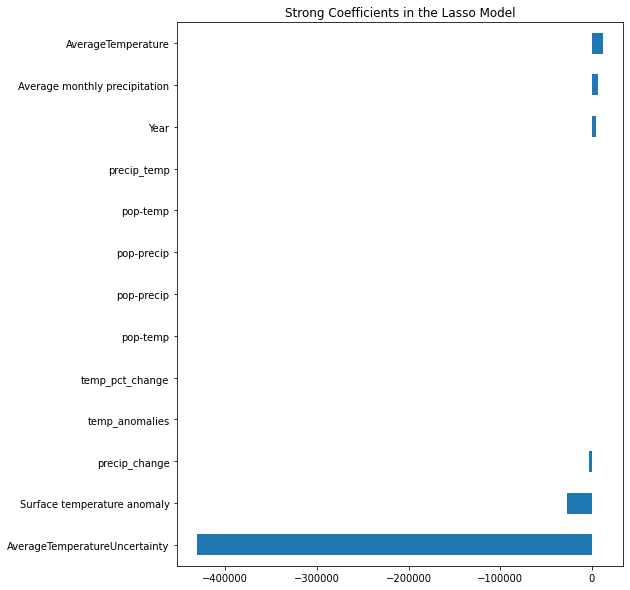

In [228]:
lasso_coefs = lasso_model.coef_

coef_lasso = pd.Series(lasso_model.coef_, index = X_train.columns)


important_coef_lasso = pd.concat([coef_lasso.sort_values().head(20)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef_lasso.plot(kind = "barh")
plt.title('Strong Coefficients in the Lasso Model')

In [229]:
important_coef_lasso.sort_values()

AverageTemperatureUncertainty   -4.309842e+05
Surface temperature anomaly     -2.680845e+04
precip_change                   -2.956119e+03
temp_anomalies                  -1.223702e+02
temp_pct_change                 -1.968189e+01
pop-temp                        -9.477467e-05
pop-precip                      -0.000000e+00
pop-precip                       3.783729e-19
pop-temp                         8.615452e-04
precip_temp                      2.297993e+02
Year                             4.660047e+03
Average monthly precipitation    6.256210e+03
AverageTemperature               1.187893e+04
dtype: float64

## Building a model, uses climate to predict yields

### Based on Country and Year

In [294]:
df.head()

,Unnamed: 0,Unnamed: 0.1,index,Country,Code_x,Year,cereals,potatoes,beans,sugar,...,yield_percent_change,goal_percent_change,yield_goal_diff,country_cat,temp_anomalies,temp_pct_change,precip_change,precip_temp,pop-temp,pop-precip
0,0,0,0,Afghanistan,AFG,1961,11151.0,86667.0,0.0,250000.0,...,0.000000,0.024,0.000000,0,14.014917,0.000000,0.000000,32.120313,9169000.0,9169000.0
1,1,1,1,Afghanistan,AFG,1962,10790.0,76667.0,0.0,250000.0,...,-0.029789,0.024,0.053789,0,13.438667,-0.041117,-0.178594,25.828087,9351000.0,9351000.0
2,2,2,2,Afghanistan,AFG,1963,9858.0,81333.0,0.0,250000.0,...,0.011065,0.024,0.012935,0,15.863417,0.180431,0.140633,32.166510,9543000.0,9543000.0
3,3,3,3,Afghanistan,AFG,1964,10828.0,86000.0,0.0,250000.0,...,0.016522,0.024,0.007478,0,12.054917,-0.240081,0.062304,29.741723,9745000.0,9745000.0
4,4,4,4,Afghanistan,AFG,1965,10989.0,88000.0,0.0,255000.0,...,0.020647,0.024,0.003353,0,14.141833,0.173117,0.030711,33.037539,9956000.0,9956000.0


In [295]:
df['Year'] = df['Year'].astype('category')

In [308]:
pre_features = df[['Year','Country']]

In [310]:
yield_df_onehot = pd.get_dummies(pre_features, columns=['Country', 'Year'], prefix = ['Country', 'Year'])
features=yield_df_onehot.loc[:, yield_df_onehot.columns != 'total_yield']

label = df['total_yield']

features.tail()

,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaijan,Country_Bahamas,...,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013
7703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [312]:
#scale features 
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
features=scaler.fit_transform(features)


#Train, test, split
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.3, random_state=42)

In [314]:
#Model Comparison

from sklearn.metrics import r2_score
def compare_models(model):
    model_name = model.__class__.__name__
    fit=model.fit(train_data,train_labels)
    y_pred=fit.predict(test_data)
    r2=r2_score(test_labels,y_pred)
    return([model_name,r2])

In [315]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

models = [
    GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
     RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
    svm.SVR(),
   DecisionTreeRegressor()
]

#Decision tree 72% accurate

In [318]:
#setting test data to columns from dataframe and excluding 'yield' values where  model is making predictions

test_df = pd.DataFrame(test_data,columns=yield_df_onehot.loc[:, yield_df_onehot.columns != 'total_yield'].columns) 

In [320]:
# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe
cntry=test_df[[col for col in test_df.columns if 'Country' in col]].stack()[test_df[[col for col in test_df.columns if 'Country' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]

#Doing the same for year 

itm=test_df[[col for col in test_df.columns if 'Year' in col]].stack()[test_df[[col for col in test_df.columns if 'Year' in col]].stack()>0]
itmlist=list(pd.DataFrame(itm).index.get_level_values(1))
items=[i.split("_")[1] for i in itmlist]

In [322]:
#Create test data frame

test_df.drop([col for col in test_df.columns if 'Year' in col],axis=1,inplace=True)
test_df.drop([col for col in test_df.columns if 'Country' in col],axis=1,inplace=True)
test_df.head()

""
0
1
2
3
4


In [323]:
#Add countries and year back in 

test_df['Country']=countries
test_df['Year']=items
test_df.head()

,Country,Year
0,Switzerland,2008
1,Turkmenistan,1997
2,United States,1980
3,Gambia,1996
4,Madagascar,1991


In [324]:
test_df.sort_values(by = ['Country', 'Year'])

,Country,Year
1408,Afghanistan,1961
1417,Afghanistan,1969
1412,Afghanistan,1975
1949,Afghanistan,1976
995,Afghanistan,1978
...,...,...
1465,Zimbabwe,2005
329,Zimbabwe,2006
544,Zimbabwe,2008
543,Zimbabwe,2009


In [325]:
model_train=list(map(compare_models,models))

print(model_train, sep = "\n")

[['GradientBoostingRegressor', 0.6348154761840509], ['RandomForestRegressor', 0.12186985302845987], ['SVR', -0.05209050619800948], ['DecisionTreeRegressor', 0.7286207071462056]]


In [326]:
clf=DecisionTreeRegressor()
model=clf.fit(train_data,train_labels)

test_df["yield_predicted"]= model.predict(test_data)
test_df["yield_actual"]=pd.DataFrame(test_labels)["total_yield"].tolist()
test_group=test_df.groupby("Country")
test_group.apply(lambda x: r2_score(x.yield_actual,x.yield_predicted))

Country
Afghanistan      -0.001382
Albania           0.440362
Algeria           0.252954
Angola           -0.140089
Argentina        -0.256088
                    ...   
Vietnam          -0.831975
Western Sahara   -1.003927
Yemen            -0.910326
Zambia           -0.073234
Zimbabwe         -0.403265
Length: 158, dtype: float64

In [329]:
model.score(test_data, test_labels)

0.7286398005969514

In [330]:
test_df

,Country,Year,yield_predicted,yield_actual
0,Switzerland,2008,515795.0,551114
1,Turkmenistan,1997,92116.0,118998
2,United States,1980,1200620.0,1191875
3,Gambia,1996,142689.0,140014
4,Madagascar,1991,612511.0,579082
...,...,...,...,...
2308,Jordan,1990,189057.0,329002
2309,Niger,1971,566800.0,439701
2310,Albania,1998,110995.0,181108
2311,Japan,1963,987548.0,776567


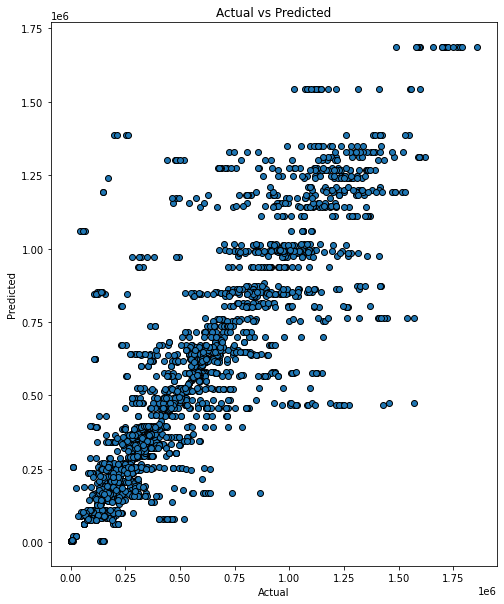

In [333]:
#run the model actual values against the predicted ones 

fig, ax = plt.subplots() 

ax.scatter(test_df["yield_actual"], test_df["yield_predicted"],edgecolors=(0, 0, 0))

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [335]:
#Export model 

import pickle 
pickle_out = open("preds.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

## Test prediction function

In [181]:
my_list = {'Country': ['Laos'], 
           'Year':[2016]}

In [339]:
test_df.to_csv('data/yield_predictions_acc.csv')

In [182]:
my_df = pd.DataFrame(my_list)

my_df

,Country,Year
0,Laos,2016


In [184]:
one_hot_var = pd.get_dummies(my_df, columns=['Country', 'Year'], prefix = ['Country', 'Year'])


one_hot_var

,Country_Laos,Year_2016
0,1,1


In [185]:
#enc.transform([['Female', 1], ['Male', 4]]).toarray()

In [186]:
yield_df_onehot

,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaijan,Country_Bahamas,...,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

In [138]:
pre_features.reset_index(inplace = True)

In [142]:
pre_features = pre_features[['Year', 'Country']]

In [340]:
pre_features

,Year,Country
0,1961,Afghanistan
1,1962,Afghanistan
2,1963,Afghanistan
3,1964,Afghanistan
4,1965,Afghanistan
...,...,...
7703,2012,Equatorial Guinea
7704,2013,Equatorial Guinea
7705,1987,Solomon Islands
7706,1988,Solomon Islands


In [144]:
enc.fit(pre_features)

enc.categories_

[array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
        1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
        1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
        1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
        2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]),
 array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
        'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
        'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
        'Bolivia', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso',
        'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
        'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
        'Comoros', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus',
        'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
        'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',


In [145]:
transformed = enc.transform([['2016','Laos']]).toarray()

In [155]:
model.predict(transformed)

array([937667.])

In [96]:
my_features=yield_df_onehot.loc[:, yield_df_onehot.columns != 'total_yield']
len(my_features)

7708

In [82]:
model.predict(my_features)

array([368241., 337457., 341191., ..., 267917., 313756., 397798.])

In [188]:
#export model 


#import pickle 
#pickle_out = open("my_pred_model.pkl", mode = "wb") 
#pickle.dump(model, pickle_out) 
#pickle_out.close()

In [343]:
features2 = pd.read_csv('data/hungerprefeatures.csv')

enc2 = OneHotEncoder(handle_unknown='ignore')

enc2.fit(features2)

OneHotEncoder(handle_unknown='ignore')

In [346]:
transformed2 = enc2.transform([[2016, 'Laos', 127349]]).toarray()


transformed2

array([[0., 0., 0., ..., 0., 0., 0.]])

In [350]:
#Load in Hunger model 
pickle_in = open('hunger_mod.pkl', 'rb')

classifier2 = pickle.load(pickle_in)

In [352]:
#test function 
prediction2 = classifier2.predict(transformed2)

#make prediction

prediction2

array([5.2])

## Both models make successful predictions